The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


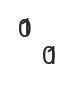

In [359]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt

# Load models together
from src.torch_utils import load_model_full
from src.multimodal_metrics import BSSVAELoss
from src.utils import get_class_initcode_keys
from src.multimodal_models import BSSVAE
from src.multimodal_train_eval import predict_multimodal, multimodal_train_eval_loops, train_multimodal_step, eval_multimodal_step
from src.multimodal_datasets import MultimodalPepTCRDataset, MultimodalCLFLatentDataset
from src.datasets import TwoStageTCRpMHCDataset, FullTCRDataset, LatentTCRpMHCDataset, TCRSpecificDataset
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
%load_ext autoreload
%autoreload 2
    
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE
from src.metrics import reconstruction_accuracy, VAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180



def get_model(folder, **kwargs):
    pt = glob.glob(folder+'/*checkpoint_best*.pt')
    pt = [x for x in pt if 'interval' not in x][0]
    js = glob.glob(folder+'/*checkpoint*.json')[0]
    model = load_model_full(pt, js, **kwargs)
    return model
    

In [12]:
m = get_model('../output/240404_FirstBestLast_comparison/mmvaes/240325_1327_BSSVAE_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_IzcVOH/',
             map_location='cpu')

Reloading best model:
epoch: 669
total: 0.24167719816201078
recon_marg: 0.058951238294695785
recon_joint: 0.06029103156074707
kld_marg: 2.8083470404482448e-05
kld_joint: 0.12240684622103679
tcr_marg_seq_accuracy: 0.48559725284576416
tcr_joint_seq_accuracy: 0.47769173979759216
pep_joint_seq_accuracy: 0.7373113036155701
pep_marg_seq_accuracy: 0.7518730163574219
wmean_seq_accuracy: 0.5605287954211235


# Use either only FullTCR or only CDR3

Use models without peptide as input ; For BSS / JM VAEs, can use the TCR-side part of the encoders

In [91]:
# For BSSVAE, Df is duplicated 3 times : because we go through the "3" modalities (TCR, Pep, paired)
# To get the TCR part, do .loc[:1960]
bssdf = pd.read_csv('../output/240324_MMVAES/240321_ADDLAYERS/240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_yOqyC6/valid_predictions_kcv_f00_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_yOqyC6.csv')
stcrdf = pd.read_csv('../output/240404_TCRONLY_onetwostage_smallLARGE/240404_1150_ExpData_TCRONLY_1stage_LARGE_256h_100l_NoTrp_KFold_0_LARGETCRP1/valid_predictions_kcv_240311_nettcr_pairedAB_expanded_noswap_f00_240404_1150_ExpData_TCRONLY_1stage_LARGE_256h_100l_NoTrp_KFold_0_LARGETCRP1.csv')
cosdf = pd.read_csv('../output/240404_TCRONLY_onetwostage_smallLARGE/240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_SmCosTCRP1/valid_predictions_kcv_240311_nettcr_pairedAB_expanded_noswap_f00_240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_SmCosTCRP1.csv')
len(bssdf.drop_duplicates(subset=['peptide','A1','A2','A3','B1','B2','B3'])), len(stcrdf)
display(bssdf.head(3))
display(stcrdf.head(3))

,peptide,A1,A2,A3,B1,B2,B3,allele,binder,target,...,z_91,z_92,z_93,z_94,z_95,z_96,z_97,z_98,z_99,fold
0,RAKFKQLL,TISGTDY,GLTSN,IQSQGGSEKLV,SGHDT,YYEEEE,ASSLRDGSEAF,HLA-B*08:01,1.0,NaN,...,-0.030315,0.630402,-0.061242,0.288611,0.848534,0.266395,0.532458,0.211411,0.190118,0
1,YLYALVYFL,TSDPSYG,QGSYDQQN,AMREGKNDYKLS,SGHDT,YYEEEE,ASSFGGVEGMNTEAF,HLA-A*02:01,1.0,NaN,...,-0.116279,0.824002,1.853908,-0.059586,0.720120,0.306077,0.669701,-0.009777,-0.135003,0
2,KLSALGINAV,TSESDYY,QEAYKQQN,AWRGGGGADGLT,MNHEY,SVGEGT,ASSWDPTYNEQF,HLA-A*02:01,1.0,NaN,...,-0.208192,0.833056,0.374255,-0.204106,0.577718,-3.375388,0.702590,-0.351612,-0.199378,0


,peptide,A1,A2,A3,B1,B2,B3,allele,partition,binder,...,z_91,z_92,z_93,z_94,z_95,z_96,z_97,z_98,z_99,fold
0,RAKFKQLL,TISGTDY,GLTSN,IQSQGGSEKLV,SGHDT,YYEEEE,ASSLRDGSEAF,HLA-B*08:01,0,1,...,2.429806,-0.625789,-1.936006,0.996946,0.239063,-1.269450,0.899635,-0.854365,0.144581,0
1,YLYALVYFL,TSDPSYG,QGSYDQQN,AMREGKNDYKLS,SGHDT,YYEEEE,ASSFGGVEGMNTEAF,HLA-A*02:01,0,1,...,-0.668173,-0.468289,3.393375,0.225074,-0.821956,1.037017,0.690047,-0.341352,-1.499044,0
2,KLSALGINAV,TSESDYY,QEAYKQQN,AWRGGGGADGLT,MNHEY,SVGEGT,ASSWDPTYNEQF,HLA-A*02:01,0,1,...,0.763271,0.696995,2.894275,0.724968,2.887076,1.084999,-0.864339,1.104071,0.026000,0


In [49]:
from sklearn.cluster import AgglomerativeClustering, HDBSCAN, OPTICS, DBSCAN, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from src.sim_utils import make_dist_matrix

def get_linkage_matrix(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    return linkage_matrix


def get_aggcluster_heatmap_plot(preds, linkage='average', distance_threshold=0.457675, title='', fn='file'):
    sample = preds.query('partition==1')[['A1', 'A2', 'A3', 'B1', 'B2', 'B3']+[z for z in preds.columns if z.startswith('z_')]+['peptide', 'original_peptide']].sort_values('original_peptide')
    sample_dist_matrix = make_dist_matrix(sample)
    # Do agglomerative clustering with hyperparameters found earlier
    agg = AgglomerativeClustering(n_clusters=None, metric='precomputed', linkage=linkage, distance_threshold=distance_threshold)
    predicted_clusters = agg.fit_predict(sample_dist_matrix.drop(columns=['peptide','original_peptide']).values)
    linkage_matrix = get_linkage_matrix(agg)
    
    # Get a PCA of the features
    features = sample[[z for z in preds.columns if z.startswith('z_')]+['peptide', 'original_peptide']]
    pca = PCA(n_components=15)
    pca_feats = pd.DataFrame(pca.fit_transform(features.drop(columns=['peptide', 'original_peptide']).values), columns = [f'PCA_{i}' for i in range(pca.n_components_)])
    # Create the colour scheme
    features = features.rename(columns={'original_peptide':'label'})
    labels = features.pop('label')
    row_colors = {k:v for k,v in zip(labels.unique(), sns.color_palette('Paired', 26))}
    mapped_colors = labels.map(row_colors).reset_index(drop=True)
    
    g = sns.clustermap(pca_feats, col_cluster=False, row_linkage=linkage_matrix, col_linkage=None, row_colors=mapped_colors, cbar_pos=(.975, .35, .035, .45),
                   label=True, cmap = 'viridis', z_score=0, dendrogram_ratio=(0.2, 0))
    fig = g.fig
    ax = g.ax_heatmap
    ax.set_yticklabels([])
    ax.set_yticks([])
    fig.suptitle(title, y=1.05)
    g.savefig(f'{fn}.png', dpi=180)

In [92]:
# Take the TCR only part for BSSVAE df
bssdm = make_dist_matrix(bssdf.loc[:1960].reset_index(drop=True), cols=['peptide','binder'])
bss_array = bssdm.iloc[:, :-2].values
tcrdm = make_dist_matrix(stcrdf.reset_index(drop=True), cols=['peptide','binder'])
tcr_array = tcrdm.iloc[:, :-2].values
cosdm = make_dist_matrix(cosdf.loc[:1960].reset_index(drop=True), cols=['peptide','binder'])
cos_array = cosdm.iloc[:, :-2].values
labels = tcrdm['peptide'].values

In [109]:
top5 = cosdm.groupby('peptide').agg(count=('binder','count')).sort_values('count',ascending=False).head(5).index
tmp = cosdm.query('peptide in @top5')
toy = tmp.loc[tmp.index, tmp.index.to_list()+['peptide']]
toy_array = toy.drop(columns=['peptide']).values
toy_triu = toy_array[np.triu(np.ones(toy_array.shape),k=1)==1]
toy_labels = toy['peptide'].values

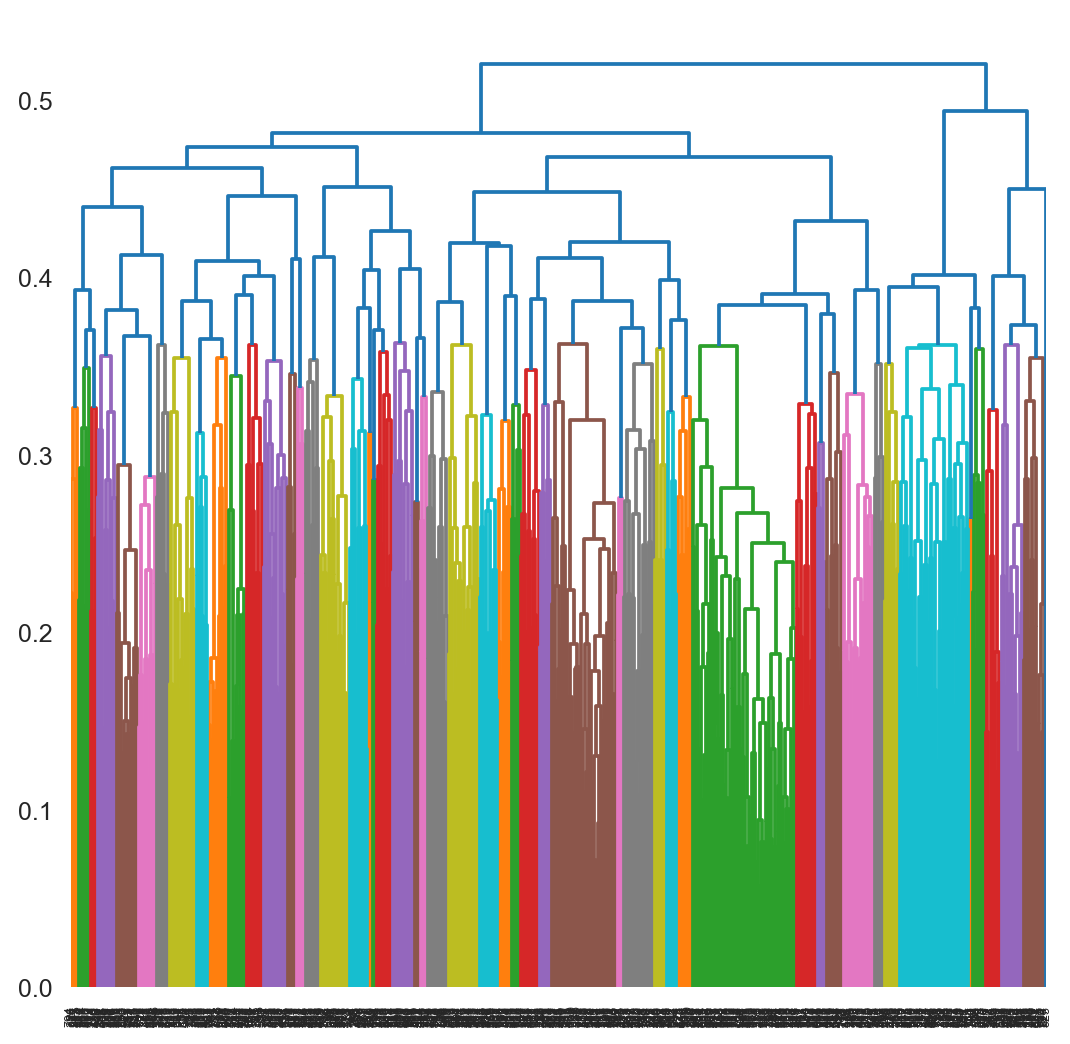

[Text(5, 0, '794'),
 Text(15, 0, '384'),
 Text(25, 0, '26'),
 Text(35, 0, '234'),
 Text(45, 0, '247'),
 Text(55, 0, '323'),
 Text(65, 0, '281'),
 Text(75, 0, '554'),
 Text(85, 0, '2'),
 Text(95, 0, '740'),
 Text(105, 0, '358'),
 Text(115, 0, '561'),
 Text(125, 0, '595'),
 Text(135, 0, '750'),
 Text(145, 0, '465'),
 Text(155, 0, '382'),
 Text(165, 0, '779'),
 Text(175, 0, '714'),
 Text(185, 0, '271'),
 Text(195, 0, '273'),
 Text(205, 0, '206'),
 Text(215, 0, '130'),
 Text(225, 0, '19'),
 Text(235, 0, '435'),
 Text(245, 0, '196'),
 Text(255, 0, '262'),
 Text(265, 0, '12'),
 Text(275, 0, '605'),
 Text(285, 0, '454'),
 Text(295, 0, '335'),
 Text(305, 0, '391'),
 Text(315, 0, '175'),
 Text(325, 0, '237'),
 Text(335, 0, '702'),
 Text(345, 0, '116'),
 Text(355, 0, '608'),
 Text(365, 0, '327'),
 Text(375, 0, '246'),
 Text(385, 0, '256'),
 Text(395, 0, '688'),
 Text(405, 0, '301'),
 Text(415, 0, '708'),
 Text(425, 0, '501'),
 Text(435, 0, '263'),
 Text(445, 0, '580'),
 Text(455, 0, '570'),
 Tex

In [116]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
# Assuming X is your distance matrix or data
Z = linkage(toy_triu, method='complete', metric='cosine', optimal_ordering=True)  # or 'single', 'complete', 'average'
f,a = plt.subplots(1,1, figsize=(7,7))
dendrogram(Z, ax=a)
plt.show()
a.get_xticklabels()
# label_colors = {k:c for k,c in zip(set(toy_labels), get_palette('Set1', len(set(toy_labels))))}
# sns.clustermap(toy.drop(columns=['peptide']), method='complete', col_cluster=False, row_colors=label_colors, figsize=(10,7))

## Tuning HP and checking metrics

In [131]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score as ch_score, davies_bouldin_score as db_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

In [134]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(cosdf['peptide'].values)

In [331]:
def get_purity(counts):
    # Purity in absolute % of a cluster, taking the majority label 
    # high = better
    sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
    return sorted_counts[list(sorted_counts.keys())[0]] / sum(sorted_counts.values())
    
def get_mixity(counts):
    # how many different labels are inside a cluster, weighted by the number of members
    # low = better
    return len(counts.keys()) / sum(counts.values())
    
def get_coherence(dist_array):
    # Assumes dist_array is the subset of the distance array for a given cluster label
    # mean distance within a cluster
    # low = better

    # get upper triangle mask without the diagonale
    mask = np.triu(np.ones(dist_array.shape), k=0) - np.eye(dist_array.shape[0])
    flat_array = dist_array[mask==1]
    return np.mean(flat_array)

def get_purity_mixity_coherence(cluster_label:int, 
                                true_labels:list, 
                                pred_labels:list, 
                                dist_array:np.array,
                                label_encoder):
    """
        For a given cluster label (int) returned by clustering.labels_, 
        Return the purity, mixity, coherence, cluster_size, and scale (==cluster_size/total_size)
        scale should be used to get a weighted average metric at the end
    """
    indices = np.where(pred_labels==cluster_label)[0]
    cluster_size = len(indices)
    if cluster_size<=1:
        # return np.nan, np.nan, np.nan, 1, 1/len(true_labels)
        return {'purity':np.nan, 'coherence':np.nan, 'cluster_size':1}

    # Query the subset of the true labels belonging to this cluster using indices 
    # Convert to int label encodings in order to use np.bincount to get purity and mixity
    subset = true_labels[indices]
    encoded_subset = label_encoder.transform(subset)
    counts = {i:k for i,k in enumerate(np.bincount(encoded_subset)) if k>0}
    
    purity = get_purity(counts)
    # mixity = get_mixity(counts)
    # index the distance matrix and return the mean distance within this cluster (i.e. coherence)
    coherence = get_coherence(dist_array[indices][:, indices])
    
    # return purity, mixity, coherence, cluster_size, cluster_size / len(true_labels)
    return {'purity':purity, 'coherence':coherence, 'cluster_size':cluster_size}

In [301]:
cos_features = cosdf[[x for x in cosdf.columns if x.startswith('z_')]]
cos_results = []

for t in tqdm(np.linspace(0.075, 1, 1500)):
    t = round(t, 5)
    c = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold=t, linkage='complete')
    c.fit(cos_array)
    
    n_cluster = len(np.unique(c.labels_))
    n_singletons = (np.bincount(c.labels_)==1).sum()
    try:
        s_score = silhouette_score(cos_features, c.labels_, metric='cosine')
    except:
        s_score = np.nan
    try:
        c_score = ch_score(cos_features, c.labels_)
    except:
        c_score = np.nan
    try:
        d_score = db_score(cos_features, c.labels_)
    except:
        d_score = np.nan
    try:
        ari_score = adjusted_rand_score(encoded_labels, c.labels_)
    except:
        ari_score = np.nan

    xd = pd.concat([pd.DataFrame(get_purity_mixity_coherence(k, true_labels, c.labels_, cos_array, label_encoder), index=[0]) for k in set(c.labels_)]).dropna()
    mean_purity = xd['purity'].mean()
    mean_coherence = xd['coherence'].mean()
    mean_cs = xd['cluster_size'].mean()
    cos_results.append({'threshold':t, 'n_cluster':n_cluster, 'n_singletons':n_singletons,
                        'mean_purity':xd['purity'].mean(), 
                        'min_purity':xd['purity'].min(), 
                        'max_purity':xd['purity'].max(), 
                        'mean_coherence':xd['coherence'].mean(), 
                        'min_coherence':xd['coherence'].min(), 
                        'max_coherence':xd['coherence'].max(), 
                        'mean_cluster_size': xd['cluster_size'].mean(),
                        'min_cluster_size': xd['cluster_size'].min(),
                        'max_cluster_size': xd['cluster_size'].max(),
                        'silhouette':s_score,
                        'ch_index':c_score, 'db_index':d_score, 'ARI':ari_score})


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [03:34<00:00,  7.01it/s]


In [302]:
tcr_features = stcrdf[[x for x in stcrdf.columns if x.startswith('z_')]]
tcr_results = []

for t in tqdm(np.linspace(0.075, 1, 1500)):
    t = round(t, 5)
    c = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold=t, linkage='complete')
    c.fit(tcr_array)
    
    n_cluster = len(np.unique(c.labels_))
    n_singletons = (np.bincount(c.labels_)==1).sum()
    try:
        s_score = silhouette_score(tcr_features, c.labels_, metric='cosine')
    except:
        s_score = np.nan
    try:
        c_score = ch_score(tcr_features, c.labels_)
    except:
        c_score = np.nan
    try:
        d_score = db_score(tcr_features, c.labels_)
    except:
        d_score = np.nan
    try:
        ari_score = adjusted_rand_score(encoded_labels, c.labels_)
    except:
        ari_score = np.nan
    xd = pd.concat([pd.DataFrame(get_purity_mixity_coherence(k, true_labels, c.labels_, tcr_array, label_encoder), index=[0]) for k in set(c.labels_)]).dropna()
    mean_purity = xd['purity'].mean()
    mean_coherence = xd['coherence'].mean()
    mean_cs = xd['cluster_size'].mean()
    tcr_results.append({'threshold':t, 'n_cluster':n_cluster, 'n_singletons':n_singletons,
                        'mean_purity':xd['purity'].mean(), 
                        'min_purity':xd['purity'].min(), 
                        'max_purity':xd['purity'].max(), 
                        'mean_coherence':xd['coherence'].mean(), 
                        'min_coherence':xd['coherence'].min(), 
                        'max_coherence':xd['coherence'].max(), 
                        'mean_cluster_size': xd['cluster_size'].mean(),
                        'min_cluster_size': xd['cluster_size'].min(),
                        'max_cluster_size': xd['cluster_size'].max(),
                        'silhouette':s_score,
                        'ch_index':c_score, 'db_index':d_score, 'ARI':ari_score})


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [06:55<00:00,  3.61it/s]


In [ ]:
bss_features = bssdf[[x for x in bssdf.columns if x.startswith('z_')]]
bss_results = []

for t in tqdm(np.linspace(0.075, 1, 1500)):
    t = round(t, 5)
    c = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold=t, linkage='complete')
    c.fit(bss_array)
    
    n_cluster = len(np.unique(c.labels_))
    n_singletons = (np.bincount(c.labels_)==1).sum()
    
    try:
        s_score = silhouette_score(bss_features, c.labels_, metric='cosine')
    except:
        s_score = np.nan
    try:
        c_score = ch_score(bss_features, c.labels_)
    except:
        c_score = np.nan
    try:
        d_score = db_score(bss_features, c.labels_)
    except:
        d_score = np.nan
    try:
        ari_score = adjusted_rand_score(encoded_labels, c.labels_)
    except:
        ari_score = np.nan
    xd = pd.concat([pd.DataFrame(get_purity_mixity_coherence(k, true_labels, c.labels_, bss_array, label_encoder), index=[0]) for k in set(c.labels_)]).dropna()
    mean_purity = xd['purity'].mean()
    mean_coherence = xd['coherence'].mean()
    mean_cs = xd['cluster_size'].mean()
    bss_results.append({'threshold':t, 'n_cluster':n_cluster, 'n_singletons':n_singletons,
                        'mean_purity':xd['purity'].mean(), 
                        'min_purity':xd['purity'].min(), 
                        'max_purity':xd['purity'].max(), 
                        'mean_coherence':xd['coherence'].mean(), 
                        'min_coherence':xd['coherence'].min(), 
                        'max_coherence':xd['coherence'].max(), 
                        'mean_cluster_size': xd['cluster_size'].mean(),
                        'min_cluster_size': xd['cluster_size'].min(),
                        'max_cluster_size': xd['cluster_size'].max(),
                        'silhouette':s_score,
                        'ch_index':c_score, 'db_index':d_score, 'ARI':ari_score})


In [304]:
cat_results = pd.concat([pd.DataFrame(cos_results).assign(input_type='cos'), 
           pd.DataFrame(tcr_results).assign(input_type='tcr'), 
           pd.DataFrame(bss_results).assign(input_type='bss')])

In [309]:
cat_results.query('mean_purity>0.6').sort_values('n_singletons')

,threshold,n_cluster,n_singletons,mean_purity,min_purity,max_purity,mean_coherence,min_coherence,max_coherence,mean_cluster_size,min_cluster_size,max_cluster_size,silhouette,ch_index,db_index,ARI,input_type
208,0.20335,949,308,0.601086,0.142857,1.0,0.162793,0.045644,0.203293,2.578783,2,18,0.131503,3.219705,1.096716,0.017356,cos
207,0.20274,957,321,0.603191,0.142857,1.0,0.162199,0.045644,0.202461,2.578616,2,18,0.131106,3.210499,1.087353,0.017370,cos
206,0.20212,964,330,0.605356,0.142857,1.0,0.161739,0.045644,0.202109,2.572555,2,18,0.130707,3.203405,1.080706,0.017144,cos
205,0.20150,969,336,0.605542,0.142857,1.0,0.161437,0.045644,0.201453,2.567141,2,18,0.130489,3.200056,1.076136,0.017061,cos
204,0.20088,977,346,0.607223,0.142857,1.0,0.160779,0.030074,0.200604,2.559429,2,18,0.130647,3.192743,1.067354,0.017045,cos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,0.07932,1954,1947,1.000000,1.000000,1.0,0.058188,0.041819,0.076831,2.000000,2,2,0.004517,16.863203,0.157201,0.000142,tcr
6,0.07870,1954,1947,1.000000,1.000000,1.0,0.058188,0.041819,0.076831,2.000000,2,2,0.004517,16.863203,0.157201,0.000142,tcr
0,0.07500,1956,1951,1.000000,1.000000,1.0,0.050812,0.041819,0.058537,2.000000,2,2,0.003684,17.787094,0.143449,0.000101,tcr
1,0.07562,1956,1951,1.000000,1.000000,1.0,0.050812,0.041819,0.058537,2.000000,2,2,0.003684,17.787094,0.143449,0.000101,tcr


In [305]:
cat_results.query('n_singletons<150 and n_cluster>50 and silhouette>0.1').dropna().sort_values('ARI', ascending=False)

,threshold,n_cluster,n_singletons,mean_purity,min_purity,max_purity,mean_coherence,min_coherence,max_coherence,mean_cluster_size,min_cluster_size,max_cluster_size,silhouette,ch_index,db_index,ARI,input_type
337,0.28296,382,4,0.427241,0.100000,1.0,0.204914,0.081295,0.252722,5.177249,2,52,0.102682,4.347183,1.943290,0.046594,cos
339,0.28419,379,4,0.425008,0.100000,1.0,0.205230,0.081295,0.252722,5.218667,2,52,0.101842,4.359808,1.951335,0.046585,cos
338,0.28357,380,4,0.425207,0.100000,1.0,0.205129,0.081295,0.252722,5.204787,2,52,0.101908,4.354669,1.948060,0.046557,cos
340,0.28481,373,4,0.422288,0.100000,1.0,0.205866,0.081295,0.252722,5.303523,2,52,0.100994,4.389465,1.966254,0.046512,cos
341,0.28542,370,4,0.421882,0.100000,1.0,0.206326,0.081295,0.252722,5.346995,2,52,0.100014,4.401682,1.971941,0.046483,cos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,0.50449,810,146,0.553143,0.166667,1.0,0.392699,0.087720,0.503715,2.733434,2,13,0.146789,4.076880,1.258759,0.011098,tcr
695,0.50387,810,146,0.553143,0.166667,1.0,0.392699,0.087720,0.503715,2.733434,2,13,0.146789,4.076880,1.258759,0.011098,tcr
697,0.50510,809,146,0.552469,0.166667,1.0,0.392952,0.087720,0.503715,2.737557,2,13,0.146367,4.079675,1.259989,0.011094,tcr
702,0.50819,798,139,0.550312,0.166667,1.0,0.394313,0.087720,0.503715,2.764795,2,13,0.145946,4.092425,1.272146,0.011092,tcr


In [360]:
cat_results.dropna().sort_values('silhouette',ascending=False)

,threshold,n_cluster,n_singletons,mean_purity,min_purity,max_purity,mean_coherence,min_coherence,max_coherence,mean_cluster_size,min_cluster_size,max_cluster_size,silhouette,ch_index,db_index,ARI,input_type
761,0.54460,670,54,0.527450,0.142857,1.000000,0.410371,0.087720,0.543187,3.095779,2,15,0.149487,4.347142,1.439276,0.013406,tcr
760,0.54398,670,54,0.527450,0.142857,1.000000,0.410371,0.087720,0.543187,3.095779,2,15,0.149487,4.347142,1.439276,0.013406,tcr
762,0.54521,670,54,0.527450,0.142857,1.000000,0.410371,0.087720,0.543187,3.095779,2,15,0.149487,4.347142,1.439276,0.013406,tcr
766,0.54768,663,51,0.525554,0.142857,1.000000,0.411093,0.087720,0.543187,3.120915,2,15,0.149368,4.374459,1.450366,0.013375,tcr
765,0.54706,663,51,0.525554,0.142857,1.000000,0.411093,0.087720,0.543187,3.120915,2,15,0.149368,4.374459,1.450366,0.013375,tcr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,0.43784,24,0,0.215301,0.084337,0.772358,0.285870,0.212371,0.306901,81.708333,23,175,0.003953,12.227458,5.040629,0.065757,cos
589,0.43846,24,0,0.215301,0.084337,0.772358,0.285870,0.212371,0.306901,81.708333,23,175,0.003953,12.227458,5.040629,0.065757,cos
2,0.07623,1956,1951,1.000000,1.000000,1.000000,0.050812,0.041819,0.058537,2.000000,2,2,0.003684,17.787094,0.143449,0.000101,tcr
1,0.07562,1956,1951,1.000000,1.000000,1.000000,0.050812,0.041819,0.058537,2.000000,2,2,0.003684,17.787094,0.143449,0.000101,tcr


In [362]:
cat_results.dropna().sort_values('mean_purity', ascending=False).query('n_singletons<1000')

,threshold,n_cluster,n_singletons,mean_purity,min_purity,max_purity,mean_coherence,min_coherence,max_coherence,mean_cluster_size,min_cluster_size,max_cluster_size,silhouette,ch_index,db_index,ARI,input_type
147,0.16571,1388,993,0.702208,0.166667,1.000000,0.134184,0.030074,0.165653,2.450633,2,14,0.098272,2.937669,0.734433,0.011202,cos
148,0.16633,1382,982,0.702181,0.166667,1.000000,0.134608,0.030074,0.166243,2.447500,2,14,0.099019,2.944856,0.737557,0.011318,cos
149,0.16694,1378,974,0.700179,0.166667,1.000000,0.134924,0.030074,0.166785,2.443069,2,14,0.099413,2.949315,0.739792,0.011313,cos
150,0.16756,1374,968,0.700014,0.166667,1.000000,0.135278,0.030074,0.167317,2.445813,2,14,0.099779,2.954923,0.742059,0.011390,cos
151,0.16818,1366,956,0.695623,0.166667,1.000000,0.135963,0.030074,0.168172,2.451220,2,14,0.100157,2.950372,0.746401,0.011458,cos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,0.52979,2,0,0.135768,0.087487,0.184049,0.315673,0.314267,0.317079,980.500000,978,983,0.017741,18.346177,10.131841,0.010910,cos
738,0.53040,2,0,0.135768,0.087487,0.184049,0.315673,0.314267,0.317079,980.500000,978,983,0.017741,18.346177,10.131841,0.010910,cos
739,0.53102,2,0,0.135768,0.087487,0.184049,0.315673,0.314267,0.317079,980.500000,978,983,0.017741,18.346177,10.131841,0.010910,cos
741,0.53225,2,0,0.135768,0.087487,0.184049,0.315673,0.314267,0.317079,980.500000,978,983,0.017741,18.346177,10.131841,0.010910,cos


In [ ]:
get_aggcluster_heatmap_plot(stcrdf, linkage='average', distance_threshold=0.461202,
                            title='Thr: 0.4612, CH: 108.499, DB: 1.81\n'
                                  'Using Pepswapped, cosine-triplet trained model \ncosine-loss only enabled for positives,'
                                  ' reconstruction/KLD trained for all datapoints',
                            fn = '../output/240223_hierachical_clustering_heatmaps/PepSwap_1stage_CosTrp.png')


In [ ]:
# Do with a limited amount of peptides

In [314]:
top15 = cosdf.groupby('peptide').agg(count=('B3','count')).sort_values('count', ascending=False).head(15).index
coslimited_df = cosdf.query('peptide in @top10')
tcrlimited_df = stcrdf.query('peptide in @top10')
bsslimited_df = bssdf.query('peptide in @top10')

In [343]:

def get_purity_mixity_coherence(cluster_label:int, 
                                true_labels:list, 
                                pred_labels:list, 
                                dist_array:np.array,
                                label_encoder):
    """
        For a given cluster label (int) returned by clustering.labels_, 
        Return the purity, mixity, coherence, cluster_size, and scale (==cluster_size/total_size)
        scale should be used to get a weighted average metric at the end
    """
    indices = np.where(pred_labels==cluster_label)[0]
    cluster_size = len(indices)
    if cluster_size<=1:
        # return np.nan, np.nan, np.nan, 1, 1/len(true_labels)
        return {'purity':np.nan, 'coherence':np.nan, 'cluster_size':1}

    # Query the subset of the true labels belonging to this cluster using indices 
    # Convert to int label encodings in order to use np.bincount to get purity and mixity
    try:
        subset = true_labels[indices]
    except:
        raise ValueError(f'{k}, {indices}, {len(true_labels)}')
    encoded_subset = label_encoder.transform(subset)
    counts = {i:k for i,k in enumerate(np.bincount(encoded_subset)) if k>0}
    
    purity = get_purity(counts)
    # mixity = get_mixity(counts)
    # index the distance matrix and return the mean distance within this cluster (i.e. coherence)
    coherence = get_coherence(dist_array[indices][:, indices])
    
    # return purity, mixity, coherence, cluster_size, cluster_size / len(true_labels)
    return {'purity':purity, 'coherence':coherence, 'cluster_size':cluster_size}

In [354]:
def get_all_metrics(features, c, array, true_labels, encoded_labels, label_encoder):
    n_cluster = len(np.unique(c.labels_))
    n_singletons = (np.bincount(c.labels_)==1).sum()
    try:
        s_score = silhouette_score(features, c.labels_, metric='cosine')
    except:
        s_score = np.nan
    try:
        c_score = ch_score(features, c.labels_)
    except:
        c_score = np.nan
    try:
        d_score = db_score(features, c.labels_)
    except:
        d_score = np.nan
    try:
        ari_score = adjusted_rand_score(encoded_labels, c.labels_)
    except:
        ari_score = np.nan
    
    xd = pd.concat([pd.DataFrame(get_purity_mixity_coherence(k, true_labels, c.labels_, array, label_encoder), index=[0])
                    for k in set(c.labels_)]).dropna()
    mean_purity = xd['purity'].mean()
    mean_coherence = xd['coherence'].mean()
    mean_cs = xd['cluster_size'].mean()
    nc_07 = len(xd.query('purity>=0.7'))
    return {'threshold':t, 'n_cluster':n_cluster, 'n_singletons':n_singletons,
                        'n_cluster_over_70p':nc_07,
                        'mean_purity':xd['purity'].mean(), 
                        'min_purity':xd['purity'].min(), 
                        'max_purity':xd['purity'].max(), 
                        'mean_coherence':xd['coherence'].mean(), 
                        'min_coherence':xd['coherence'].min(), 
                        'max_coherence':xd['coherence'].max(), 
                        'mean_cluster_size': xd['cluster_size'].mean(),
                        'min_cluster_size': xd['cluster_size'].min(),
                        'max_cluster_size': xd['cluster_size'].max(),
                        'silhouette':s_score,
                        'ch_index':c_score, 'db_index':d_score, 'ARI':ari_score}

In [338]:
# Take the TCR only part for BSSVAE df
bssdm_limited = make_dist_matrix(bsslimited_df.iloc[:1211].reset_index(drop=True), cols=['peptide','binder'])
bss_limited_array = bssdm_limited.iloc[:, :-2].values

tcrdm_limited = make_dist_matrix(tcrlimited_df.reset_index(drop=True), cols=['peptide','binder'])
tcr_limited_array = tcrdm_limited.iloc[:, :-2].values

cosdm_limited = make_dist_matrix(coslimited_df.reset_index(drop=True), cols=['peptide','binder'])
cos_limited_array = cosdm_limited.iloc[:, :-2].values
true_limited_labels = cosdm_limited['peptide'].values


In [339]:
from sklearn.preprocessing import LabelEncoder
label_limited_encoder = LabelEncoder()
encoded_limited_labels = label_limited_encoder.fit_transform(cosdm_limited['peptide'].values)

In [340]:
bss_limited_array.shape, tcr_limited_array.shape, cos_limited_array.shape

((1211, 1211), (1211, 1211), (1211, 1211))

In [356]:
cos_features = coslimited_df[[x for x in coslimited_df.columns if x.startswith('z_')]].reset_index(drop=True)
bss_features = bsslimited_df[[x for x in bsslimited_df.columns if x.startswith('z_')]].reset_index(drop=True)
tcr_features = tcrlimited_df[[x for x in tcrlimited_df.columns if x.startswith('z_')]].reset_index(drop=True)
limited_results = []

for t in tqdm(np.linspace(0.075, 1, 1500)):
    t = round(t, 5)
    # Cos Part
    c = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold=t, linkage='complete')
    c.fit(cos_limited_array)
    cos_results = get_all_metrics(cos_features, c, cos_limited_array, true_limited_labels, encoded_limited_labels, label_limited_encoder)
    cos_results['input_type']='cos'
    limited_results.append(cos_results)

    # TCR part
    c = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold=t, linkage='complete')
    c.fit(tcr_limited_array)
    tcr_results = get_all_metrics(tcr_features, c, tcr_limited_array, true_limited_labels, encoded_limited_labels,
                                label_limited_encoder)
    tcr_results['input_type'] = 'tcr'
    limited_results.append(tcr_results)

    c = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold=t, linkage='complete')
    c.fit(bss_limited_array)
    bss_results = get_all_metrics(bss_features, c, bss_limited_array, true_limited_labels, encoded_limited_labels,
                                  label_limited_encoder)
    bss_results['input_type']='bss'
    limited_results.append(bss_results)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [07:05<00:00,  3.53it/s]


In [357]:
pd.DataFrame(limited_results).dropna().query('n_singletons<300').sort_values('mean_purity',ascending=False)

,threshold,n_cluster,n_singletons,n_cluster_over_70p,mean_purity,min_purity,max_purity,mean_coherence,min_coherence,max_coherence,mean_cluster_size,min_cluster_size,max_cluster_size,silhouette,ch_index,db_index,ARI,input_type
591,0.19656,639,298,129,0.688153,0.250000,1.000,0.157695,0.065980,0.196330,2.677419,2,14,0.122018,3.182533,0.980691,0.015028,cos
597,0.19780,628,286,127,0.683753,0.250000,1.000,0.158696,0.065980,0.197706,2.704678,2,14,0.124956,3.199725,0.992748,0.015368,cos
594,0.19718,632,290,127,0.683705,0.250000,1.000,0.158394,0.065980,0.197042,2.692982,2,14,0.124065,3.191707,0.987538,0.015288,cos
600,0.19842,623,281,126,0.682779,0.250000,1.000,0.159209,0.065980,0.198302,2.719298,2,14,0.126259,3.208412,0.997489,0.016079,cos
603,0.19903,622,280,126,0.682779,0.250000,1.000,0.159260,0.065980,0.198302,2.722222,2,14,0.126684,3.211133,0.998935,0.016119,cos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2067,0.50017,2,0,0,0.233572,0.192143,0.275,0.292350,0.271947,0.312753,605.500000,40,1171,0.032889,32.546033,2.554540,-0.001731,cos
2070,0.50078,2,0,0,0.233572,0.192143,0.275,0.292350,0.271947,0.312753,605.500000,40,1171,0.032889,32.546033,2.554540,-0.001731,cos
2073,0.50140,2,0,0,0.233572,0.192143,0.275,0.292350,0.271947,0.312753,605.500000,40,1171,0.032889,32.546033,2.554540,-0.001731,cos
2076,0.50202,2,0,0,0.233572,0.192143,0.275,0.292350,0.271947,0.312753,605.500000,40,1171,0.032889,32.546033,2.554540,-0.001731,cos


NameError: name 'resdf' is not defined